# Pattern Recognition Homework 3
* **Date** 11/28/2016
* **Author** [Haonan Chen](https://chaonan99.github.io/)
* **Student No.** 2013011449
* **Class** 32

## Highlight
* Multi classifier
* Select different number of features
* P-value based feature selection
* Model based feature selection
* PCA decomposition

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import *
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_table("dataset3.txt", header=None)
test_df = pd.read_table("dataset4.txt", header=None)
le = LabelEncoder()
le.fit(['M','F'])
y_train = le.transform(np.char.upper(train_df.loc[:, 10].values.astype(str)))
y_test = le.transform(np.char.upper(test_df.loc[:, 10].values.astype(str)))

In [3]:
classifier_names = ["Bayes", "LDA", "LSVM", "RBF SVM", "MLP"]
classifiers = [
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LinearSVC(C=0.025),
    SVC(gamma=2, C=1),
    MLPClassifier(alpha=1e-5, hidden_layer_sizes=12, random_state=1),
]
selectors = [
#     number of feature experiment
#     SelectKBest(f_classif, k=9),  # Actually an empty selector
#     SelectKBest(f_classif, k=8),
#     SelectKBest(f_classif, k=7),
#     SelectKBest(f_classif, k=6),
#     SelectKBest(f_classif, k=5),
#     SelectKBest(f_classif, k=4),
#     SelectKBest(f_classif, k=3),
#     SelectKBest(f_classif, k=2),
#     SelectKBest(f_classif, k=1),
#     p-value experiment
    SelectKBest(chi2, k=3),
    SelectKBest(f_classif, k=3),
    SelectKBest(mutual_info_classif, k=3),
#     RFE(LogisticRegression(), 3),
#     RFE(LinearSVC(C=0.005), 3),
#     RFE(LinearSVC(C=0.005, penalty="l1", dual=False), 3),
#     RFE(ExtraTreesClassifier(), 3),
#     SelectFromModel(LogisticRegression()),
#     SelectFromModel(LinearSVC(C=0.005)),
#     SelectFromModel(LinearSVC(C=0.005, penalty="l1", dual=False)),
#     SelectFromModel(ExtraTreesClassifier()),
]

def do_prediction(clf, X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, y_train)
    return accuracy_score(clf.predict(X_test), y_test)

def do_selection_and_prediction(sel, clf, X_train, X_test, y_train, y_test):
    sel.fit(X_train, y_train)
    return do_prediction(clf, sel.transform(X_train), sel.transform(X_test), y_train, y_test)

In [4]:
print("Training accuracy")
pd.DataFrame([["{0:.2f}%".format(do_selection_and_prediction(sel, clf, train_df.loc[:, 0:9],
            train_df.loc[:, 0:9], y_train, y_train)*100) for clf in classifiers] for sel in selectors],
            columns=classifier_names)

Training accuracy


,Bayes,LDA,LSVM,RBF SVM,MLP
0,90.57%,91.19%,91.09%,91.93%,91.09%
1,90.99%,90.67%,91.30%,91.93%,90.88%
2,90.25%,91.19%,91.30%,91.93%,90.88%


In [5]:
print("Test accuracy")
pd.DataFrame([["{0:.2f}%".format(do_selection_and_prediction(sel, clf, train_df.loc[:, 0:9],
            test_df.loc[:, 0:9], y_train, y_test)*100) for clf in classifiers] for sel in selectors],
            columns=classifier_names)

Test accuracy


,Bayes,LDA,LSVM,RBF SVM,MLP
0,86.59%,90.55%,88.11%,87.80%,90.85%
1,87.80%,89.63%,88.72%,88.41%,89.63%
2,86.89%,89.63%,88.72%,88.41%,88.72%


Feature ranking:


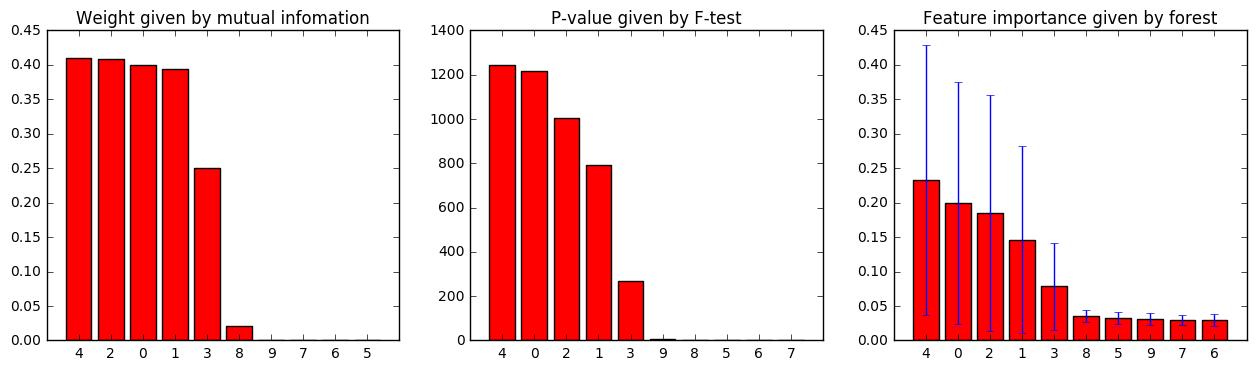

In [6]:
f, axes = plt.subplots(1, 3)
scaler = StandardScaler()
scaler.fit(train_df.loc[:, 0:9])
X_train = scaler.transform(train_df.loc[:, 0:9])
plot_clfs = [
    SelectKBest(mutual_info_classif, k=3),
    SelectKBest(f_classif, k=3),
    ExtraTreesClassifier(n_estimators=250, random_state=0)
]
for i, clf in enumerate(plot_clfs):
    clf.fit(X_train, y_train)
    if hasattr(clf, 'scores_'):
        importances = clf.scores_
        indices = np.argsort(importances)[::-1]
        axes[i].bar(range(X_train.shape[1]), importances[indices],
           color="r", align="center")
    else:
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
        axes[i].bar(range(X_train.shape[1]), importances[indices],
           color="r", align="center", yerr=std[indices])
    plt.sca(axes[i])
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])

print("Feature ranking:")
axes[0].set_title("Weight given by mutual infomation")
axes[1].set_title("P-value given by F-test")
axes[2].set_title("Feature importance given by forest")
f.subplots_adjust(left=-1, right=1)
plt.show()

In [7]:
pca = PCA(n_components=2)
pca.fit(train_df.loc[:, 0:9])
X_train = pca.transform(train_df.loc[:, 0:9])
X_test = pca.transform(test_df.loc[:, 0:9])
pca_res = pd.DataFrame([["{0:.2f}%".format(do_prediction(clf, X_train,
            X_train, y_train, y_train)*100) for clf in classifiers],
            ["{0:.2f}%".format(do_prediction(clf, X_train,
            X_test, y_train, y_test)*100) for clf in classifiers]], index=["train", "test"], columns=classifier_names)
# pca_res.to_latex("tmp.tex")
pca_res

,Bayes,LDA,LSVM,RBF SVM,MLP
train,89.94%,89.83%,89.94%,90.88%,90.04%
test,87.50%,87.50%,87.80%,89.33%,89.94%


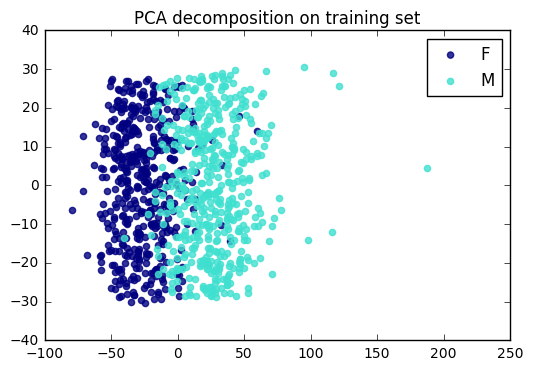

In [8]:
plt.figure()
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0, 1], ["F","M"]):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA decomposition on training set')
# plt.savefig("../doc/resource/pca_decomposition.png",dpi=200)
plt.show()